In [10]:
import os

import pandas as pd

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
import nltk
nltk.download("stopwords")


from sqlalchemy import create_engine
from dotenv import load_dotenv
load_dotenv()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fagaleev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
connection_string = os.getenv('DB_URL')
alchemyEngine   = create_engine(connection_string, pool_recycle=3600);
dbConnection    = alchemyEngine.connect();

In [18]:
data = pd.read_sql("""
select id, title, summary, text, publication_datetime, url  
from publications
where source in ('CONSULTANT', 'BUH')
""", dbConnection)

In [19]:
data.head()

,id,title,summary,text,publication_datetime,url
0,1,Нужно ли включать расходы на зарплатные карты ...,"Минфин разъяснил, должна ли организация включа...","Минфин разъяснил, должна ли организация включа...",2020-11-12 16:50:00,https://buh.ru/news/uchet_nalogi/120810/
1,2,Когда организации и ИП на АУСН получат первое ...,"ФНС разъяснила, когда организации и ИП, выбрав...","ФНС разъяснила, когда организации и ИП, выбрав...",2022-07-06 09:55:00,https://buh.ru/news/uchet_nalogi/151670/
2,3,"Минфин рассказал, будут ли упразднены бумажные...",Минфин пока не планирует переход на составлени...,Минфин пока не планирует переход на составлени...,2022-06-23 17:15:00,https://buh.ru/news/uchet_nalogi/151204/
3,4,Опрос на БУХ.1С: во сколько лет можно стать гл...,Каждый пятый опрошенный читатель БУХ.1С уверен...,Каждый пятый опрошенный читатель БУХ.1С уверен...,2021-01-19 13:30:00,https://buh.ru/news/uchet_nalogi/123690/
4,5,"Минфин не будет повышать НДФЛ в 2022 году, но ...",Минфин не планирует в 2022 году повышать налог...,Минфин не планирует в 2022 году повышать налог...,2021-12-28 17:08:00,https://buh.ru/news/uchet_nalogi/138942/


In [20]:
news_text = data.title + ". " + data.summary

In [21]:
russian_stopwords = stopwords.words("russian")
vectorizer_model = CountVectorizer(stop_words=russian_stopwords)

In [22]:
topic_model = BERTopic(verbose=True, 
                       language='multilingual',
                       diversity=0.2, vectorizer_model=vectorizer_model, 
                       nr_topics=50)

In [23]:
%%time
topics, probs = topic_model.fit_transform(news_text)

Batches:   0%|          | 0/298 [00:00<?, ?it/s]

2022-10-08 13:54:52,142 - BERTopic - Transformed documents to Embeddings
2022-10-08 13:55:07,153 - BERTopic - Reduced dimensionality
2022-10-08 13:55:07,461 - BERTopic - Clustered reduced embeddings
2022-10-08 13:56:26,815 - BERTopic - Reduced number of topics from 162 to 51


CPU times: user 14min 38s, sys: 3min 48s, total: 18min 27s
Wall time: 13min 33s


In [24]:
data['topic_id'] = topic_model.topics_

In [26]:
data.query("topic_id==0").text.iloc[0]

'Минфин\n\nиндикатор риска для контроля за соблюдением законодательства о ККТ, в т.ч. насколько полно организация или ИП учитывает выручку. Контрольные мероприятия могут провести, если есть зарегистрированные кассы, но\n\nв автоматизированной информационной системе налоговых органов нет фискальных данных.\n\nИндикатор\n\n.'

In [28]:
topics_over_time = topic_model.topics_over_time(news_text, data.publication_datetime.to_list(), nr_bins=20)

20it [04:25, 13.29s/it]


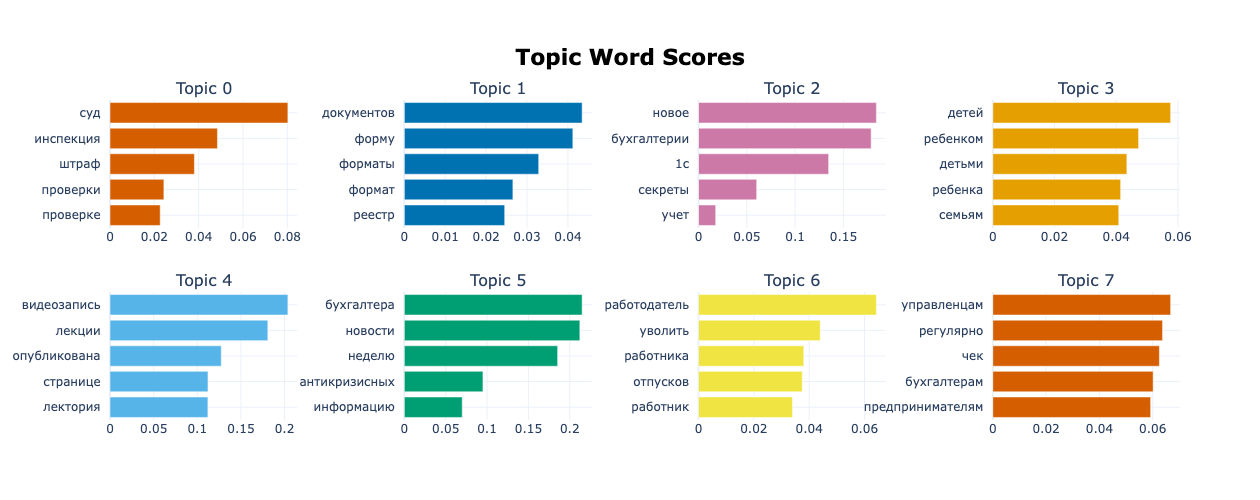

In [29]:
topic_model.visualize_barchart()

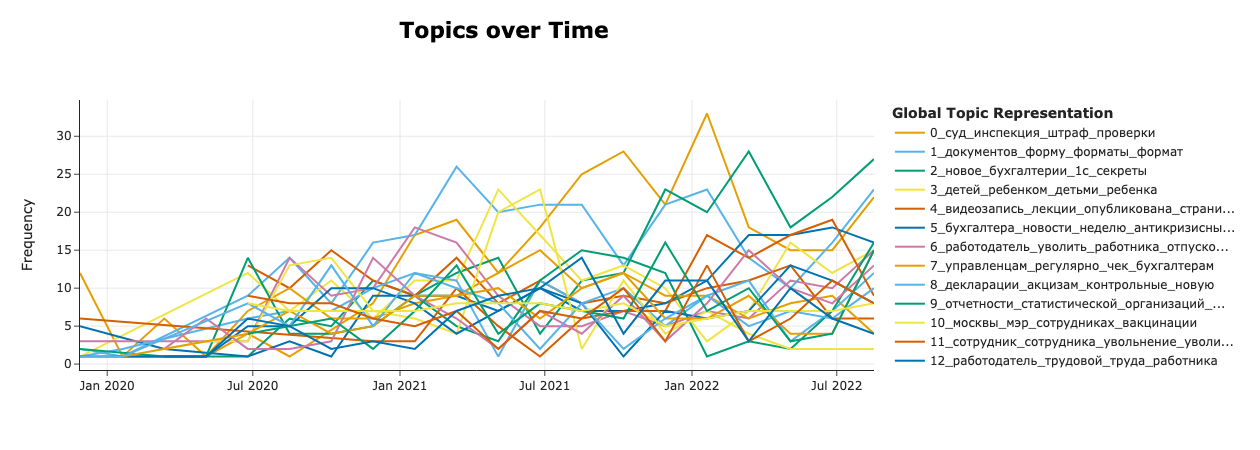

In [31]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [34]:
topic_model.get_representative_docs(topic=22)

['Власти Москвы объявили 31 декабря выходным днем. Мэр Москвы Сергей Собянин заявил в телеэфире, что 31 декабря 2020 года объявлен в столице выходным днем.',
 'Как работаем и отдыхаем в июне. В этом году День России 12 июня выпадает на воскресенье, поэтому понедельник 13 июня — выходной.',
 'Президент объявил нерабочими дни между майскими праздниками. Президент РФ Владимир Путин подпишет указ, который объявит нерабочими дни между майскими праздниками. Об этом глава государства сообщил в ходе встречи с вице-премьером Татьяной Голиковой и главой Роспотребнадзора Анной Поповой.',
 'С 16 ноября сертификат о вакцинации против коронавируса можно распечатать в МФЦ. Граждане',
 'Граждан предупредили о единственном способе оформления COVID-сертификатов по тесту на антитела. Минцифры предупредило граждан, что оформить сертификат по результатам теста на антитела к COVID-19 можно только на Едином портале госсуслуг. Соответствующая информация размещена на',
 'Коронавирус: обзор главных событий с 22

In [35]:
topic_model.save('buh_tm')

In [37]:
data.query("topic_id==1").sort_values(by="publication_datetime", ascending=False)

,id,title,summary,text,publication_datetime,url,topic_id
4595,4414,ФНС установит для перевозчиков формат электрон...,ФНС РФ разработала формат электронного договор...,ФНС РФ разработала формат электронного договор...,2022-10-07 14:50:00,https://buh.ru/news/uchet_nalogi/155274/,1
4074,3900,"ФНС изменит список стран, с которыми осуществл...",ФНС подготовила новый перечень государств и те...,ФНС подготовила новый перечень государств и те...,2022-10-07 09:15:00,https://buh.ru/news/uchet_nalogi/155249/,1
303,293,"ФНС изменит перечень государств, с которыми на...",ФНС изменит перечень иностранных государств и ...,ФНС изменит перечень иностранных государств и ...,2022-10-06 12:50:00,https://buh.ru/news/uchet_nalogi/155223/,1
5644,5449,ФНС введет для перевозчиков формат электронног...,ФНС РФ разработала формат электронного заказа....,ФНС РФ разработала формат электронного заказа....,2022-10-03 09:10:00,https://buh.ru/news/uchet_nalogi/155064/,1
7353,7228,Разработали формат заказа или заявки при перев...,ФНС выставила на общественное обсуждение проек...,ФНС выставила на общественное обсуждение проек...,2022-10-03 00:00:00,http://www.consultant.ru/legalnews/20478/,1
...,...,...,...,...,...,...,...
6233,6020,ФНС утвердила новые формы сообщений банков о с...,ФНС РФ своим утвердила новые формы и форматы с...,ФНС РФ своим утвердила новые формы и форматы с...,2020-07-07 09:55:00,https://buh.ru/news/uchet_nalogi/114350/,1
4382,4216,"ФНС рассказала, что изменилось в формах сообще...","ФНС предупредила налогоплательщиков, что с 3 и...","ФНС предупредила налогоплательщиков, что с 3 и...",2020-07-03 14:30:00,https://buh.ru/news/uchet_nalogi/114183/,1
3656,6935,Обновление формата кассового чека: что учесть ...,,"\n\nОбратите внимание: планировалось, что с 1 ...",2020-02-21 00:00:00,http://www.consultant.ru/legalnews/12274/,1
9078,9065,Организации с обособками: утверждена форма для...,ФНС утвердила,"ФНС утвердила\n\n, которая пригодится организа...",2019-12-24 00:00:00,http://www.consultant.ru/legalnews/11879/,1


In [38]:
rbc_news = pd.read_sql("""
select id, title, summary, text, publication_datetime, url  
from publications
where source in ('RBC')
""", dbConnection)


In [39]:
rbc_news

,id,title,summary,text,publication_datetime,url
0,1,Пусть халтурит: почему преданных сотрудников б...,Пару десятилетий назад типичный карьерный путь...,Пару десятилетий назад типичный карьерный путь...,2020-02-05,https://trends.rbc.ru/trends/education/5e3402a...
1,2,Разумный город: шесть инновационных мегаполисо...,"Уличные фонари со сверхскоростным интернетом, ...","Уличные фонари со сверхскоростным интернетом, ...",2019-10-23,https://trends.rbc.ru/trends/innovation/5daf0d...
2,3,Общее будущее: как ретейл берет курс на устойч...,Материал подготовлен по итогам первой ESG-конф...,Материал подготовлен по итогам первой ESG-конф...,2021-06-25,https://trends.rbc.ru/trends/green/cmrm/60d30e...
3,4,Метан из раковины: перспективы «зеленой» энерг...,Сейчас в городах Земли проживают лишь 55% миро...,Сейчас в городах Земли проживают лишь 55% миро...,2019-09-11,https://trends.rbc.ru/trends/green/5d77837c9a7...
4,5,Благотворительность вместо новогодних подарков...,Сама концепция alternative giving («альтернати...,Сама концепция alternative giving («альтернати...,2020-12-15,https://trends.rbc.ru/trends/social/5fd78ff19a...
...,...,...,...,...,...,...
5159,5160,Сон: что о нем известно и как правильно его ор...,,\n\n\n\nСлушайте нас на любой удобной платформ...,2022-08-29,https://trends.rbc.ru/trends/social/6307964c9a...
5160,5161,Колония на Луне и частные космические станции:...,26 октября 2020 года исследователи NASA подтве...,26 октября 2020 года исследователи NASA подтве...,2020-10-30,https://trends.rbc.ru/trends/futurology/5f9c2e...
5161,5162,Новые маски будут сами находить коронавирус: д...,"В США создали защитную маску, которая","В США создали защитную маску, которая\n\nопред...",2021-07-02,https://trends.rbc.ru/trends/industry/60df2970...
5162,5163,Как циклическая экономика может сгладить ущерб...,Циклическая экономика — она же экономика замкн...,Циклическая экономика — она же экономика замкн...,2020-03-30,https://trends.rbc.ru/trends/green/5d66893d9a7...


In [40]:
topic_model_rbc = BERTopic(verbose=True, 
                       language='multilingual',
                       diversity=0.2, vectorizer_model=vectorizer_model, 
                       nr_topics=50)

In [62]:
news_rbc = rbc_news.title + ". " + rbc_news.summary

In [63]:
%%time
topics, probs = topic_model_rbc.fit_transform(news_rbc.to_list())

Batches:   0%|          | 0/162 [00:00<?, ?it/s]

2022-10-08 14:47:45,185 - BERTopic - Transformed documents to Embeddings
2022-10-08 14:47:49,341 - BERTopic - Reduced dimensionality
2022-10-08 14:47:49,509 - BERTopic - Clustered reduced embeddings
2022-10-08 14:48:45,271 - BERTopic - Reduced number of topics from 96 to 51


CPU times: user 9min 11s, sys: 2min 35s, total: 11min 46s
Wall time: 8min 28s


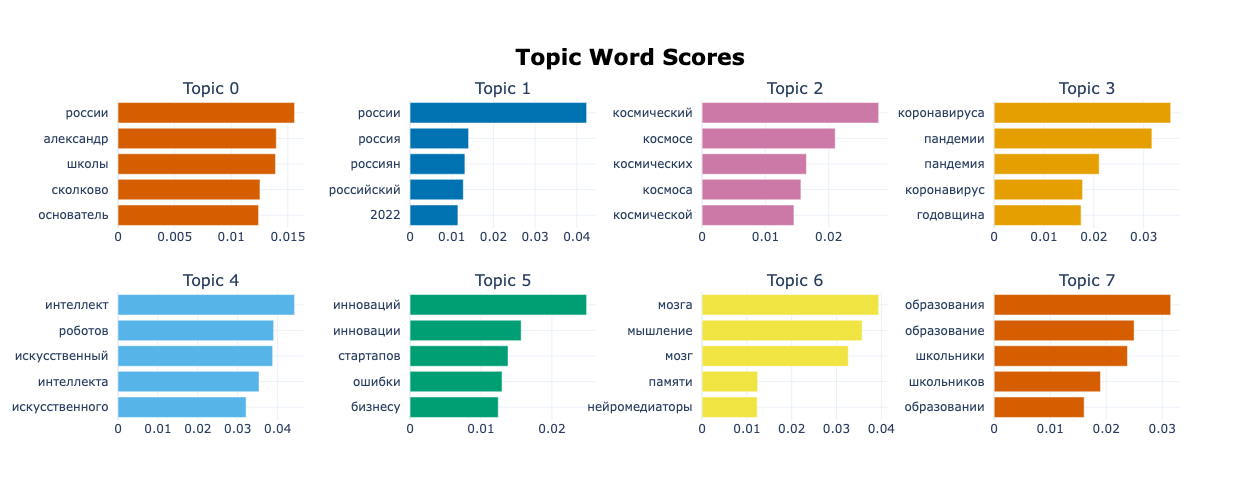

In [64]:
topic_model_rbc.visualize_barchart()

In [65]:
topics_over_time = topic_model_rbc.topics_over_time(news_rbc.to_list(), rbc_news.publication_datetime.to_list(), nr_bins=20)

20it [03:44, 11.24s/it]


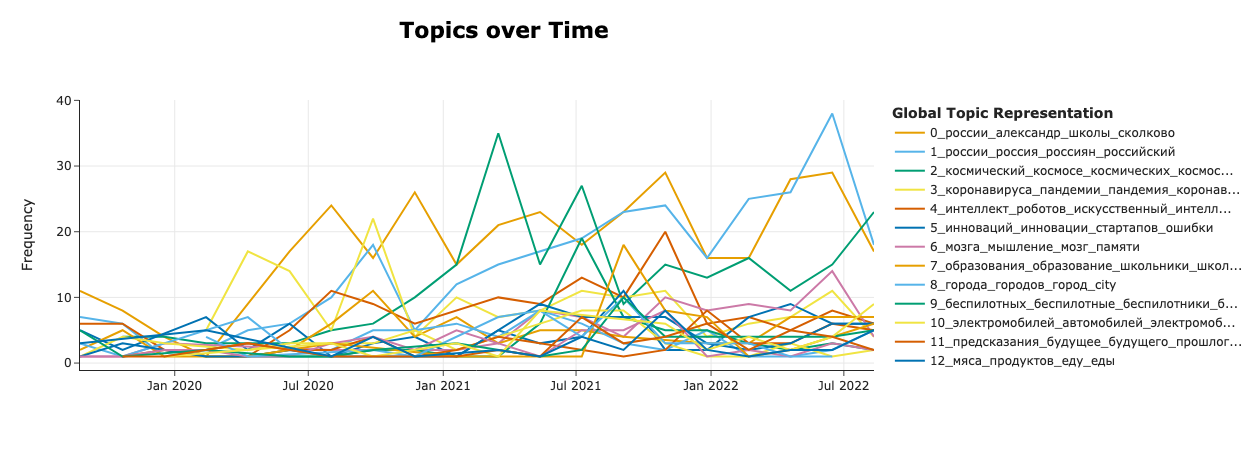

In [66]:
topic_model_rbc.visualize_topics_over_time(topics_over_time, top_n_topics=20)

In [68]:
topic_model_rbc.get_representative_docs(topic=1)

['Что нужно знать про ковид-паспорта\xa0— в семи карточках. , каждый пятый непривитый россиянин готов к вакцинации, ради того, чтобы получить ковид-паспорт и снова путешествовать. При этом 42% опрошенных не планируют делать прививку ни при каких условиях. У ВЦИОМ данные отличаются: 46% респондентов заявили, что не против сделать прививку или поддержат родственников, которые решат привиться. Больше интересных цифр о вакцинации в России мы',
 'Утечка умов: треть айтишников планируют уехать из России. ',
 'Что будет завтра: 45% россиян не строят планов на будущее. ']

In [69]:
rbc_news['topic_id'] = topic_model_rbc.topics_

In [82]:
rbc_news.query('topic_id==6').sort_values(by='publication_datetime', ascending=False).iloc[:20]

,id,title,summary,text,publication_datetime,url,topic_id
1810,1806,"Ложка и планшет: как общаться с человеком, кот...",Боковой амиотрофический склероз (БАС) — редкое...,Боковой амиотрофический склероз (БАС) — редкое...,2022-10-07,https://trends.rbc.ru/trends/social/633fd6469a...,6
5098,5095,Что такое иллюзия контроля и чем она может быт...,,\n\n\n\nЭтот материал ребята из команды Трендо...,2022-09-01,https://trends.rbc.ru/trends/social/6290702b9a...,6
4415,4577,Когнитивные способности: как и зачем постоянно...,"О том, что мозг — это «мышца», которую тоже ну...","О том, что мозг — это «мышца», которую тоже ну...",2022-08-31,https://trends.rbc.ru/trends/education/630cda1...,6
89,85,Детская амнезия: почему мы не помним первый го...,можно на сайте издания Scientific American.,можно на сайте издания Scientific American.\n\...,2022-08-29,https://trends.rbc.ru/trends/social/630c65f69a...,6
5029,5023,Редактирование памяти: фантастика или реальность?,американского когнитивного психолога и специал...,американского когнитивного психолога и специал...,2022-08-10,https://trends.rbc.ru/trends/futurology/62f37a...,6
2109,2099,Редактирование памяти: фантастика или реальность?,американского когнитивного психолога и специал...,американского когнитивного психолога и специал...,2022-08-10,https://trends.rbc.ru/trends/industry/62f37ad8...,6
3287,3281,Рифмы и чертоги разума: простые способы лучше ...,Кривая забывания — это визуальное представлени...,Кривая забывания — это визуальное представлени...,2022-08-08,https://trends.rbc.ru/trends/education/62e7e4f...,6
2846,2835,"Что такое когнитивно-поведенческая терапия, и ...","КПТ — это вид терапии, в которой негативные мы...","КПТ — это вид терапии, в которой негативные мы...",2022-08-08,https://trends.rbc.ru/trends/education/62e7e6d...,6
4970,4963,Объяснить необъяснимое: что такое квалиа и как...,,\n\n\n\nЭтот материал ребята из команды Трендо...,2022-08-03,https://trends.rbc.ru/trends/social/628157b69a...,6
3017,3031,Объяснить необъяснимое: что такое квалиа и как...,,\n\n\n\nЭтот материал ребята из команды Трендо...,2022-08-03,https://trends.rbc.ru/trends/education/628157b...,6


In [80]:
topic_model_rbc.save("rbc_tm")